In [309]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [310]:
debut = '2019-11-01 12:55:00'
split = '2019-11-05 12:55:00'
fin = '2019-11-08 12:55:00'

In [311]:
############################
######## LIBRAIRIES ########
############################

import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

In [312]:
############################
######## FONCTIONS ########
###########################
name = ''
def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    print (name+' : ',results.summary())
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    print (name+' : ',durbinwatson)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    print (name+' : ',results_diff.summary())
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    print (name+' : ',durbinwatson_diff)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    print(Fore.LIGHTBLUE_EX,'\nTEST DE NORMALITE : JARQUE-BERA '+name,Style.RESET_ALL)
    if p_value <= 0.05:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on ",\
        "refuse l’hypothèse de la normalité de la série ")
        print(Fore.GREEN,'TEST JARQUE-BERRA VALIDE',Style.RESET_ALL)
    else:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est supérieure au seuil de signification de 5%",\
        " donc on refusel’hypothèse de la normalité de la série ")
        print(Fore.RED,"TEST JARQUE-BERA ECHOUE",Style.RESET_ALL)
    return()

def skewness(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: SKEWNESS "+name,Style.RESET_ALL)
    if skew < -0.1 or skew > 0.1:
        print("Puisque le skewness (",round(skew,4),") de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST SKEWNESS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST SKEWNESS ECHOUE",Style.RESET_ALL)
    return()

def kurtos(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: KURTOSIS "+name,Style.RESET_ALL)
    if kurtosis > -3.1 or kurtosis < 3.1:
        print("Puisque le skewness (",round(kurtosis,4),") de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST DE KURTOSIS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST KURTOSIS ECHOUE",Style.RESET_ALL)
    return()
def autocor(df):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE "+name,Style.RESET_ALL)
    plot_acf(df['Close'])
    plot_pacf(df['Close'], lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def autocor_diff(diff):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE EUR/USD EN PREMIERE DIFFERENCE",Style.RESET_ALL)
    plot_acf(diff)
    plot_pacf(diff, lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
        print("D’après le corrélogramme de la série ‘EURUSD’ en différence première, nous constatons que la première bande associée à la fonction    d’auto-corrélation partielle sort significativement de l’intervalle de confiance représenté par les pointillés, donc nous retenons p = 1 comme nombre de retards pour les régressions des tests ADF")
        p = 1
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def test_stationarity(timeseries,lag):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for '+name)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test pour la paire : '+name)
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return(dfoutput)

def test_adf(df):
    print(Fore.BLUE,"\nADF MODELE 3 pour la paire : "+name,Style.RESET_ALL)
    X = df['Close'].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        print("La p_value est de ",result_adf[1],"et est bien supérieure à 0.05. On accèpte l'hypothèse nulle Ho. Il n'y a pas de trend significatif")
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)

    print(Fore.BLUE,"\nADF MODELE 2 (LAG)",Style.RESET_ALL)
    X = diff[1:].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05 :
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print("La série est stationnaire en intégration d'ordre 1")
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)
    return()

def isname(pair):
    global name
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(chfusd):
        name = 'CHF/USD'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(jpyusd):
        name = 'JPY/USD'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'CHF/USD':
        pair = chfusd
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'JPY/USD':
        pair = jpyusd
        
    return(pair)

def transform():
    df = pd.DataFrame()
    inv = 'NON'
    dfname = input('Entrez le nom du fichier à transformer (sans le .csv)')
    print('Parsing des dates. Cela peut prendre quelques minutes')
    df = pd.read_csv(dfname+'.csv',parse_dates=['Local time'])
    inv = input('Doit-on inverser les devises? (NON - OUI)')
    if inv == 'OUI' or inv == 'oui' or inv == 'o' or inv =='O':
        print('inversion des devises')
        df['Open'] = 1 / df['Open']
        df['High'] = 1 / df['High']
        df['Low'] = 1 / df['Low']
        df['Close'] = 1 / df['Close']
        df.to_csv(dfname+'_transformed.csv')
    else:
        df.to_csv(dfname+'_transformed.csv')
        
    print('Done pour ',dfname+'.csv')
    return()

In [313]:
base_eurusd = pd.read_csv('EURUSD.csv')
try:
    base_eurusd = base_eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_eurusd['Local time'] = pd.to_datetime(base_eurusd['Local time'])

base_audusd = pd.read_csv('AUDUSD.csv')

try:
    base_audusd = base_audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_audusd['Local time'] = pd.to_datetime(base_audusd['Local time'])

base_chfusd = pd.read_csv('USDCHF.csv')
#base_chfusd = transform(base_chfusd)
try:
    base_chfusd = base_chfusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_chfusd['Local time'] = pd.to_datetime(base_chfusd['Local time'])

base_gbpusd = pd.read_csv('GBPUSD.csv')

try:
    base_gbpusd = base_gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_gbpusd['Local time'] = pd.to_datetime(base_gbpusd['Local time'])

base_jpyusd = pd.read_csv('USDJPY.csv')
#base_jpyusd = transform(base_jpyusd)

try:
    base_jpyusd = base_jpyusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_jpyusd['Local time'] = pd.to_datetime(base_jpyusd['Local time'])


print('Vérification des longueur de bases (',base_eurusd.shape[0],') :')

if base_eurusd.shape[0] != base_audusd.shape[0] or base_eurusd.shape[0] != base_chfusd.shape[0] \
or base_eurusd.shape[0] != base_gbpusd.shape[0] or base_eurusd.shape[0] != base_jpyusd.shape[0] :
    print(Fore.RED,'=================== > NON VALIDE',Style.RESET_ALL)

else:
    print(Fore.GREEN,'========================= > VALIDE',Style.RESET_ALL)
    
print('\nEUR/USD : ')
print('Début : ',base_eurusd.iloc[0]['Local time'])
print('Fin : ',base_eurusd.iloc[-1]['Local time'])
print('Shape : ',base_eurusd.shape)

print('\nAUD/USD : ')
print('Début : ',base_audusd.iloc[0]['Local time'])
print('Fin : ',base_audusd.iloc[-1]['Local time'])
print('Shape : ',base_audusd.shape)

print('\nCHF/USD : ')
print('Début : ',base_chfusd.iloc[0]['Local time'])
print('Fin : ',base_chfusd.iloc[-1]['Local time'])
print('Shape : ',base_chfusd.shape)

print('\nGBP/USD : ')
print('Début : ',base_gbpusd.iloc[0]['Local time'])
print('Fin : ',base_gbpusd.iloc[-1]['Local time'])
print('Shape : ',base_gbpusd.shape)

print('\nJPY/USD : ')
print('Début : ',base_jpyusd.iloc[0]['Local time'])
print('Fin : ',base_jpyusd.iloc[-1]['Local time'])
print('Shape : ',base_jpyusd.shape)

print('\nPremière date : ',base_eurusd.iloc[0]['Local time'],['Local time'])
print('\nDernière date : ',base_eurusd.iloc[-1]['Local time'],['Local time'],'\n')

#debut = input('Entrez la valeur du début (YYY-MM-DD HH:MM:SS) : ')
#split = input('Entrez la valeur du split (YYY-MM-DD HH:MM:SS) : ')
#fin = input('Entrez la valeur de la fin (YYY-MM-DD HH:MM:SS) : ')

eurusd = base_eurusd[(base_eurusd['Local time'] >= debut)&(base_eurusd['Local time'] <= split)]
audusd = base_audusd[(base_audusd['Local time'] >= debut)&(base_audusd['Local time'] <= split)]
chfusd = base_chfusd[(base_chfusd['Local time'] >= debut)&(base_chfusd['Local time'] <= split)]
gbpusd = base_gbpusd[(base_gbpusd['Local time'] >= debut)&(base_gbpusd['Local time'] <= split)]
jpyusd = base_jpyusd[(base_jpyusd['Local time'] >= debut)&(base_jpyusd['Local time'] <= split)]

bt_eurusd = base_eurusd[(base_eurusd['Local time'] > split)&(base_eurusd['Local time'] <= fin)]
bt_audusd = base_audusd[(base_audusd['Local time'] > split)&(base_audusd['Local time'] <= fin)]
bt_chfusd = base_chfusd[(base_chfusd['Local time'] > split)&(base_chfusd['Local time'] <= fin)]
bt_gbpusd = base_gbpusd[(base_gbpusd['Local time'] > split)&(base_gbpusd['Local time'] <= fin)]
bt_jpyusd = base_jpyusd[(base_jpyusd['Local time'] > split)&(base_jpyusd['Local time'] <= fin)]

PAIR = [eurusd,audusd,chfusd,gbpusd,jpyusd]
bt_PAIR = [bt_eurusd,bt_audusd,bt_chfusd,bt_gbpusd,bt_jpyusd]

Vérification des longueur de bases ( 225504 ) :
 ========================= > VALIDE 

EUR/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

AUD/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

CHF/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

GBP/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

JPY/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

Première date :  2017-02-28 00:00:00 ['Local time']

Dernière date :  2020-02-27 23:55:00 ['Local time'] 



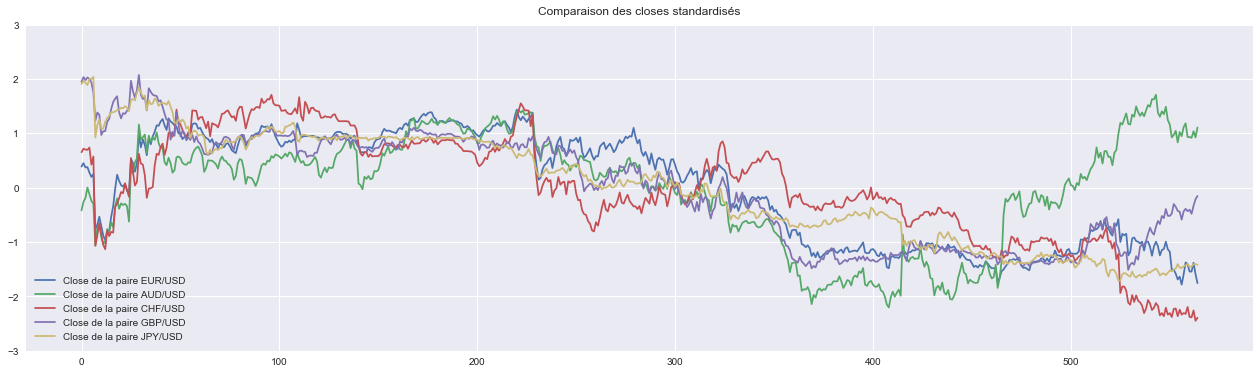

In [314]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-3, 3)
    plt.title(label='Comparaison des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close']),label='Close de la paire '+name,)
    plt.legend()

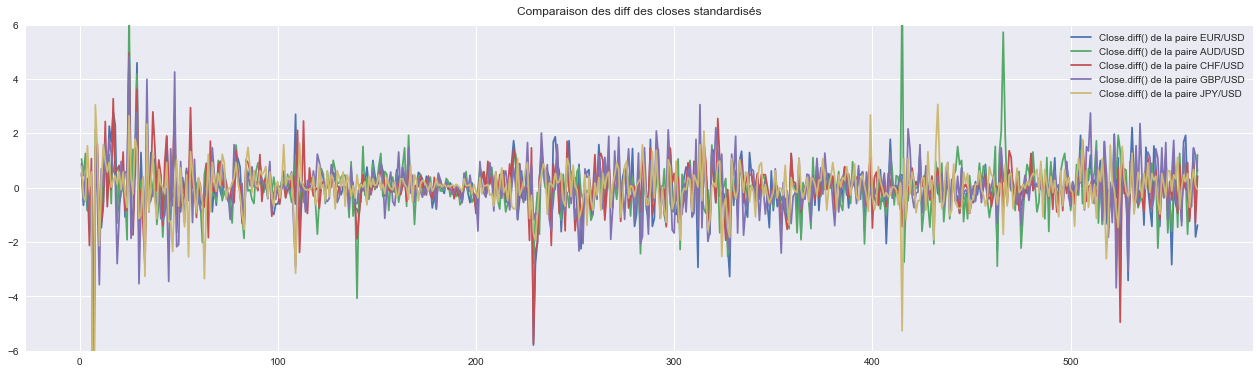

In [315]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-6, 6)
    plt.title(label='Comparaison des diff des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close'].diff()),label='Close.diff() de la paire '+name,)
    plt.legend()

EUR/USD :                                   OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.058e+08
Date:                Wed, 04 Mar 2020   Prob (F-statistic):                        0.00
Time:                        14:46:10   Log-Likelihood:                          2566.9
No. Observations:                 565   AIC:                                     -5132.
Df Residuals:                     564   BIC:                                     -5127.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

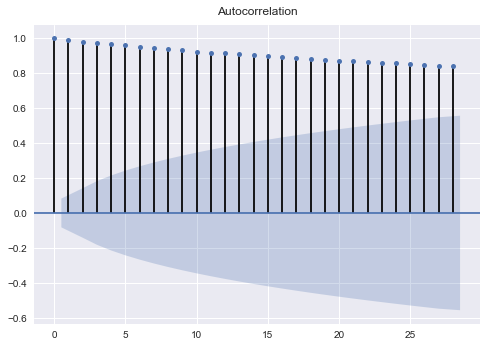

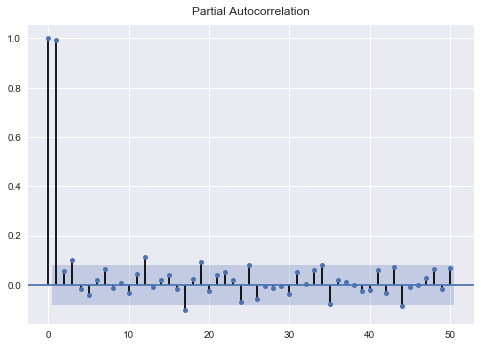

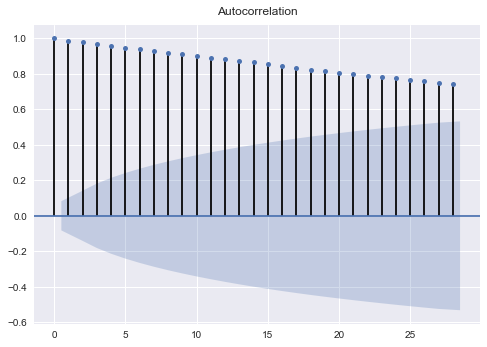

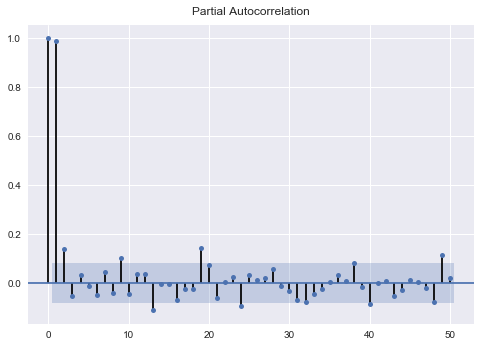

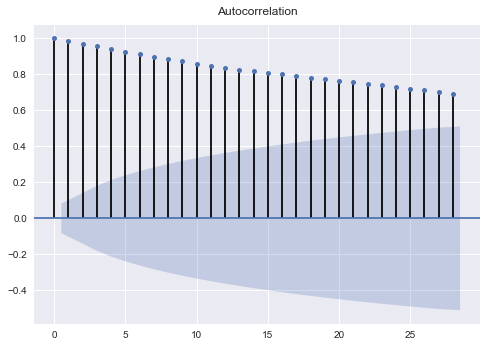

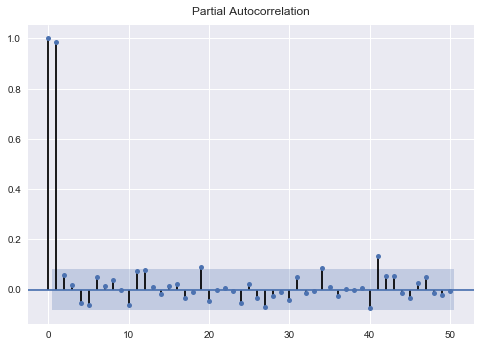

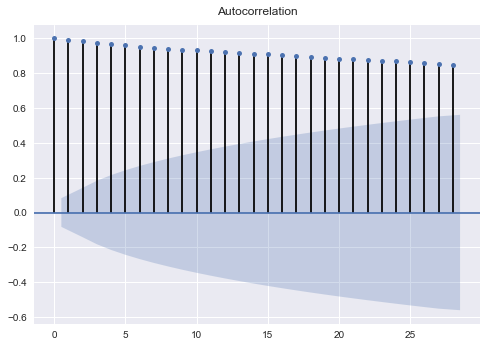

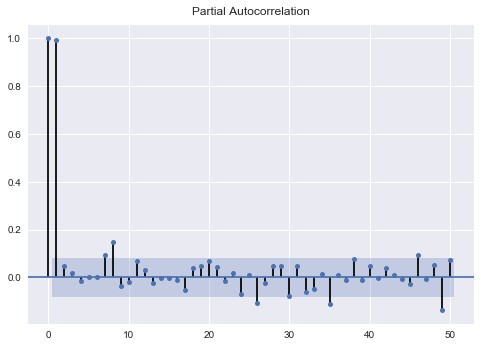

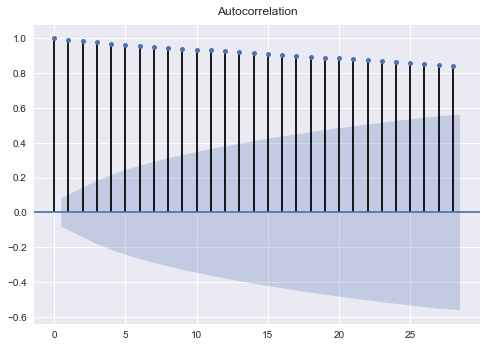

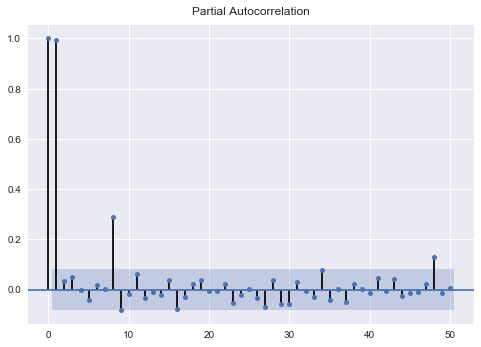

In [316]:
for pair in PAIR:
    
    name = isname(pair)
    
    model = sm.OLS(pair['Close'],pair.index)
    results = model.fit()
    residuals = results.resid
    summary = results.summary()

    jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)
    
    print(Fore.YELLOW,'POUR LA PAIRE '+name,Style.RESET_ALL)
    jarque_berra(pair)
    skewness(pair)
    kurtos(pair)
    autocor(pair)
    

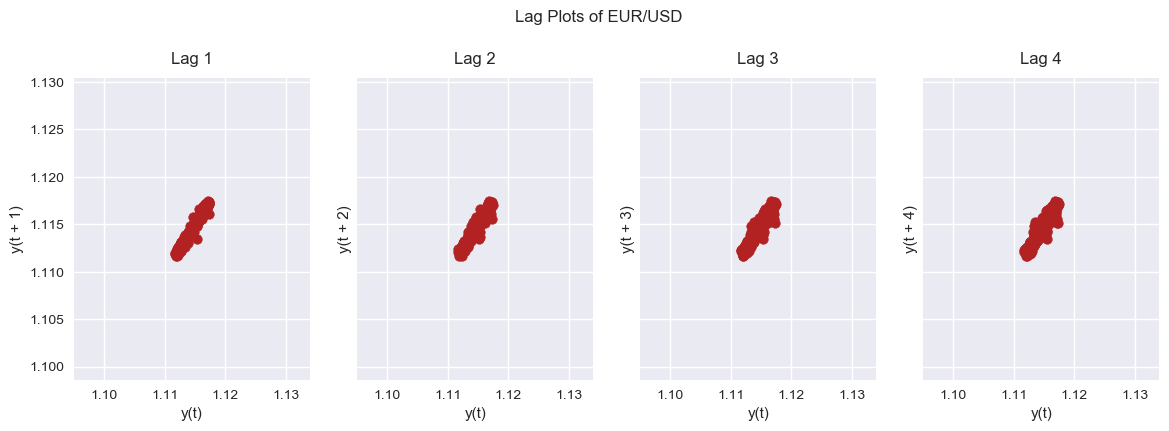

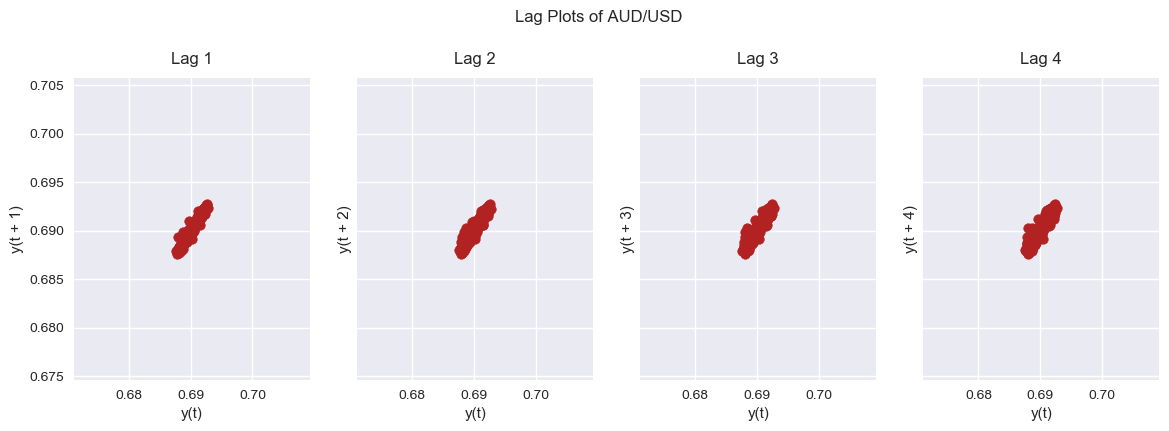

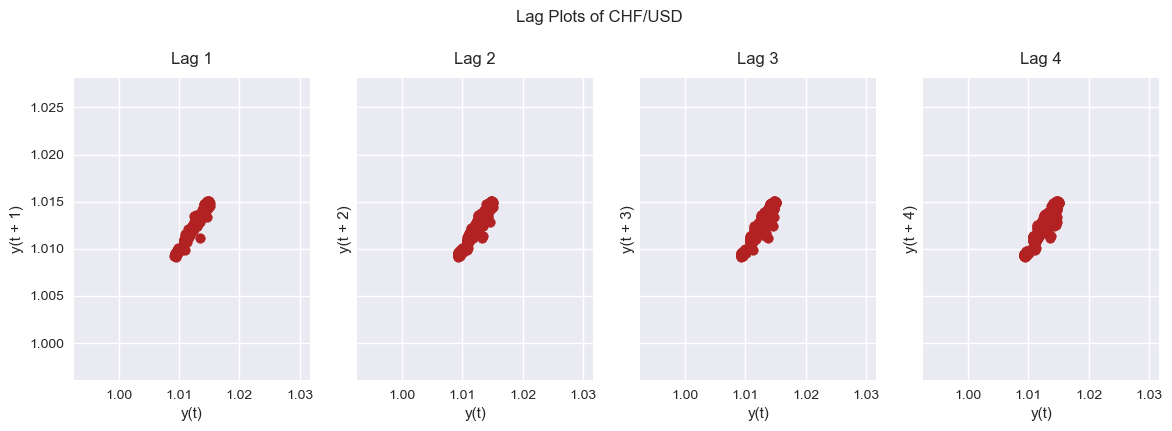

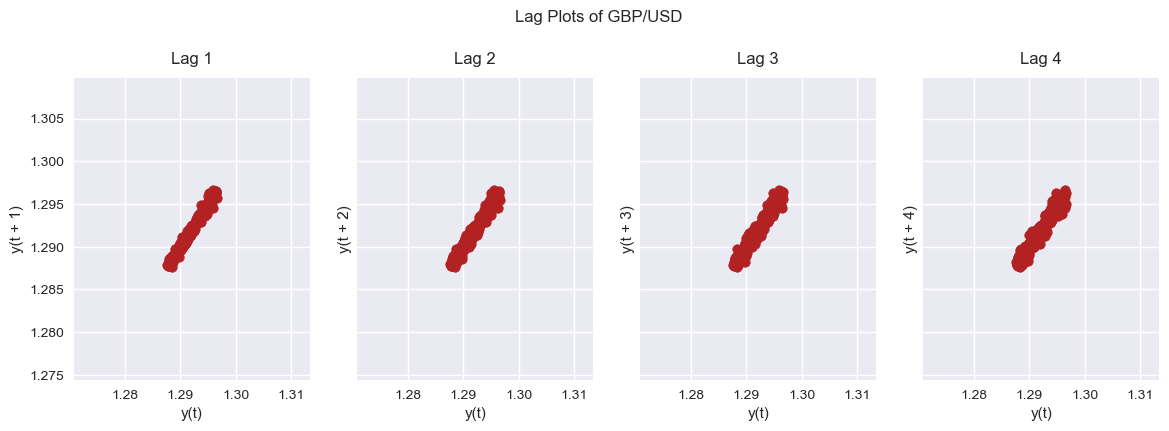

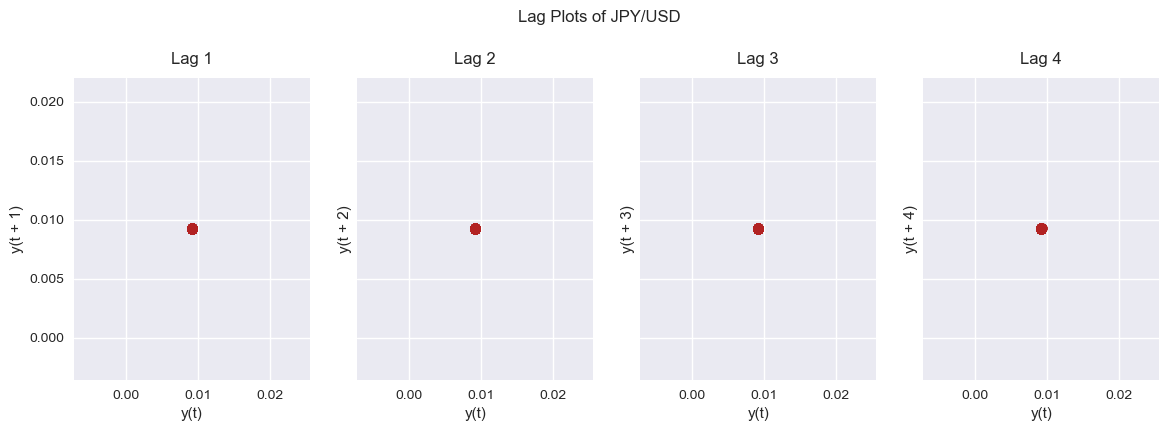

In [317]:
from pandas.plotting import lag_plot

for pair in PAIR:
    name = isname(pair)
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

    ss = pair[['Local time','Close']]
    #ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(14,4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()):
        lag_plot(ss.Close, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle('Lag Plots of '+name+' Closes \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    


    fig.suptitle('Lag Plots of '+name, y=1.05)    
    plt.show()

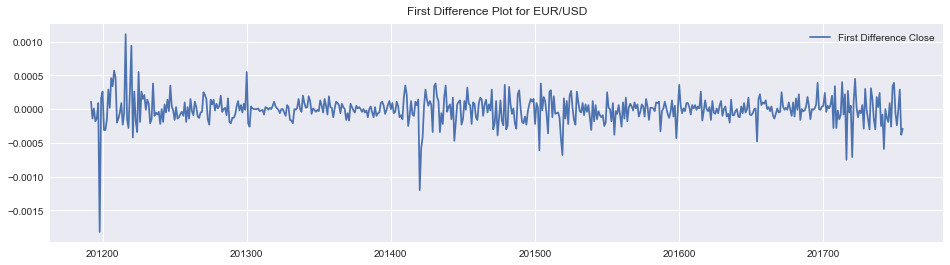

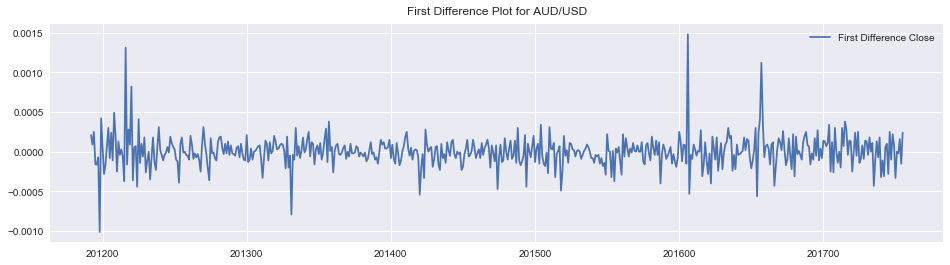

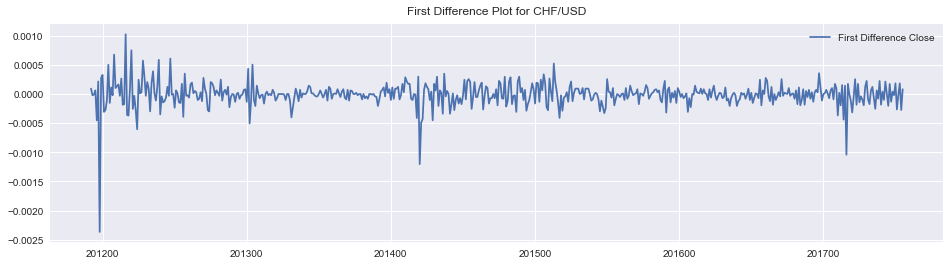

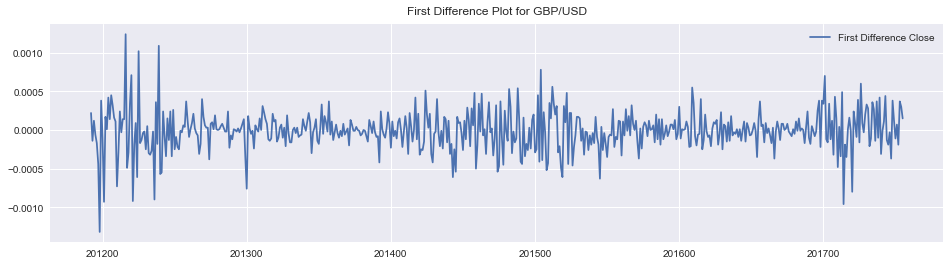

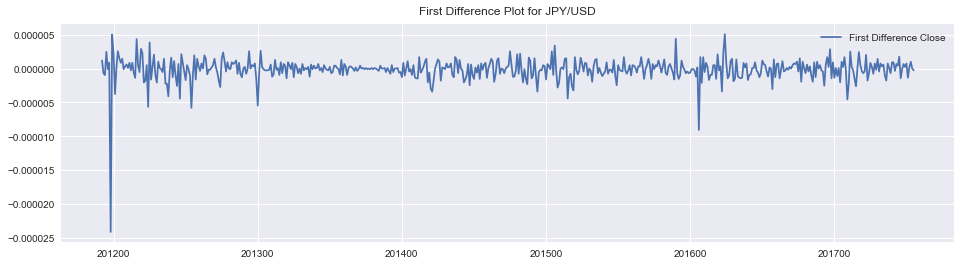

In [318]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))
    plt.plot(diff,label='First Difference Close')
    plt.title(label='First Difference Plot for '+name)
    plt.legend()



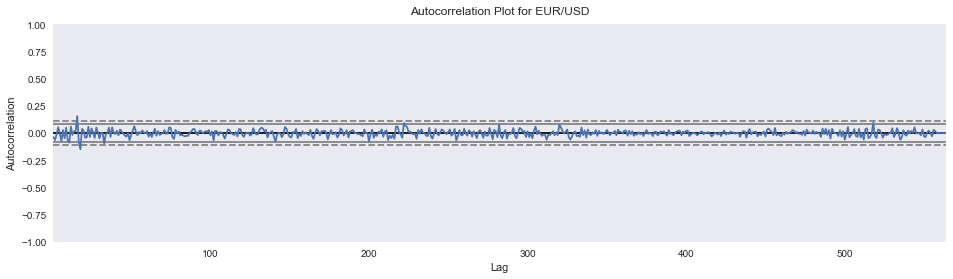

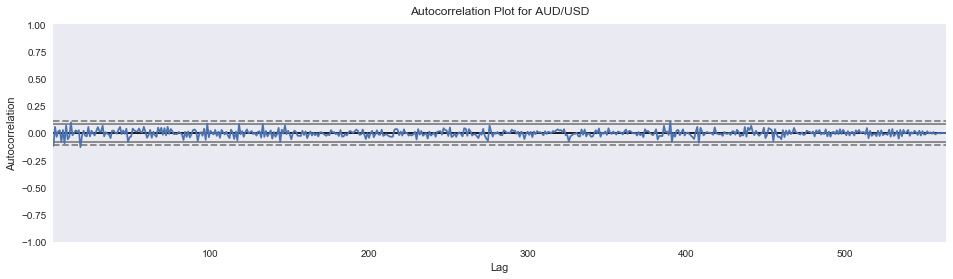

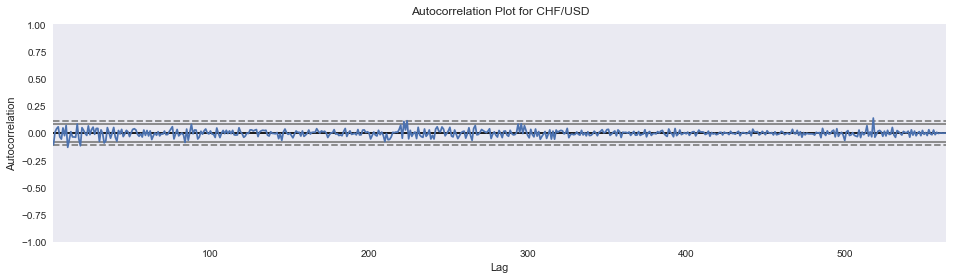

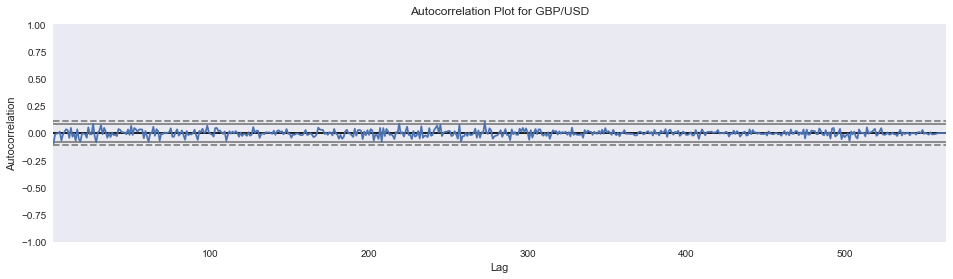

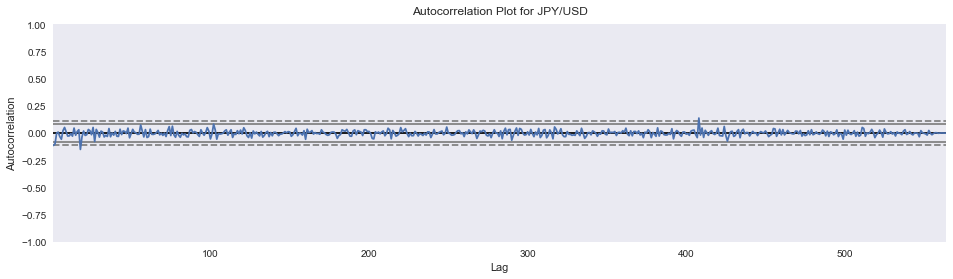

In [319]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))

    pd.plotting.autocorrelation_plot(diff[1:])
    plt.title(label='Autocorrelation Plot for '+name)
    

In [320]:
'''for pair in PAIR:
    name = isname(pair)
    timeseries = pair['Close']
    timeseries.index = pair['Local time']
    test_stationarity(timeseries)'''

"for pair in PAIR:\n    name = isname(pair)\n    timeseries = pair['Close']\n    timeseries.index = pair['Local time']\n    test_stationarity(timeseries)"

In [321]:
df = pd.DataFrame()
for pair in PAIR:
    name = isname(pair)
    df[name] = list(pair['Close'])
df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD
EUR/USD,1.000000,0.625446,0.804805,0.866714,0.855147
AUD/USD,0.625446,1.000000,0.196056,0.605394,0.369034
CHF/USD,0.804805,0.196056,1.000000,0.671627,0.805507
GBP/USD,0.866714,0.605394,0.671627,1.000000,0.927119
JPY/USD,0.855147,0.369034,0.805507,0.927119,1.000000


In [322]:
INTEGRE = []
for col in range(1,len(df.corr())):
    for ind in range(col):
        if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
            INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))
        
INTEGRE  = list(set(INTEGRE))
print('Les paires ',INTEGRE,' sont correlées et permettent un factorisation.')

Les paires  [('EUR/USD', 'AUD/USD'), ('GBP/USD', 'JPY/USD'), ('CHF/USD', 'GBP/USD'), ('EUR/USD', 'CHF/USD'), ('AUD/USD', 'GBP/USD'), ('CHF/USD', 'JPY/USD'), ('EUR/USD', 'GBP/USD'), ('EUR/USD', 'JPY/USD')]  sont correlées et permettent un factorisation.


In [323]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
print('Le KMO du modèle est de :',kmo_model)
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    if kmo_all[loop] >= 0.6:
        print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquet',Style.RESET_ALL)
    else:
        print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)

Le KMO du modèle est de : 0.6574067892784207
 EUR/USD   a un kmo considéré comme   adéquet 
 AUD/USD   a un kmo donsidéré comme   inadéquat 
 CHF/USD   a un kmo considéré comme   adéquet 
 GBP/USD   a un kmo considéré comme   adéquet 
 JPY/USD   a un kmo considéré comme   adéquet 


/opt/anaconda3/envs/FinTech/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [324]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
print('Dans le test de Barlett, on ibserve un chi2 à ',chi_square_value,' et une p_value à', p_value)
if p_value < 0.05:
    print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
else:
    print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )

Dans le test de Barlett, on ibserve un chi2 à  3685.5047753077856  et une p_value à 0.0
 Statistically significant   ce qui signifie que la matrice de correlation observée n'est pas une identity matrix


In [325]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(df)
print(fa.loadings_)
#fa.analyze(df, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

[[ 0.96909578  0.04483569  0.22626039]
 [ 0.5956489   0.72858007  0.06867779]
 [ 0.79832079 -0.40409958  0.21777393]
 [ 0.95170602  0.07745995 -0.26099693]
 [ 0.93978708 -0.24318913 -0.19753085]]


In [326]:
ev

array([3.76879264, 0.87347559, 0.26939451, 0.06277002, 0.02556724])

In [327]:
v

array([ 3.72020450e+00,  7.61276625e-01,  2.10473783e-01,  1.57433287e-07,
       -2.72551464e-07])

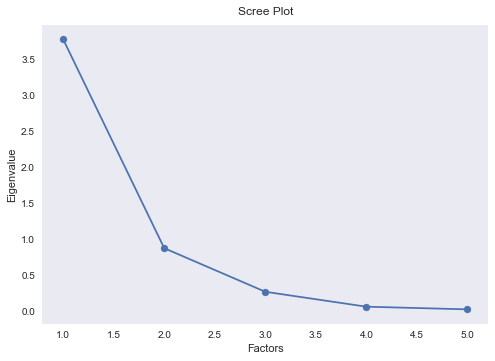

In [328]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [329]:
PRINCIPAL_COMPOSANT = []
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print('\r\n'+name+' : ',ev[loop]," ===> ",end='')
    if ev[loop] >= 1:
        print('On garde le facteur car >1')
        PRINCIPAL_COMPOSANT.append((name,ev[loop]))
    else:
        print('On retire le facteur car <1')

print('\nRésumé des composants principaux gardés :')        
PRINCIPAL_COMPOSANT        


EUR/USD :  3.768792639549986  ===> On garde le facteur car >1

AUD/USD :  0.8734755907473845  ===> On retire le facteur car <1

CHF/USD :  0.26939450582396574  ===> On retire le facteur car <1

GBP/USD :  0.06277002224350868  ===> On retire le facteur car <1

JPY/USD :  0.02556724163515385  ===> On retire le facteur car <1

Résumé des composants principaux gardés :


[('EUR/USD', 3.768792639549986)]

In [330]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [331]:
x_pca = pca.transform(df)
x_pca.shape

(565, 2)

Text(0, 0.5, 'Second Principal Component')

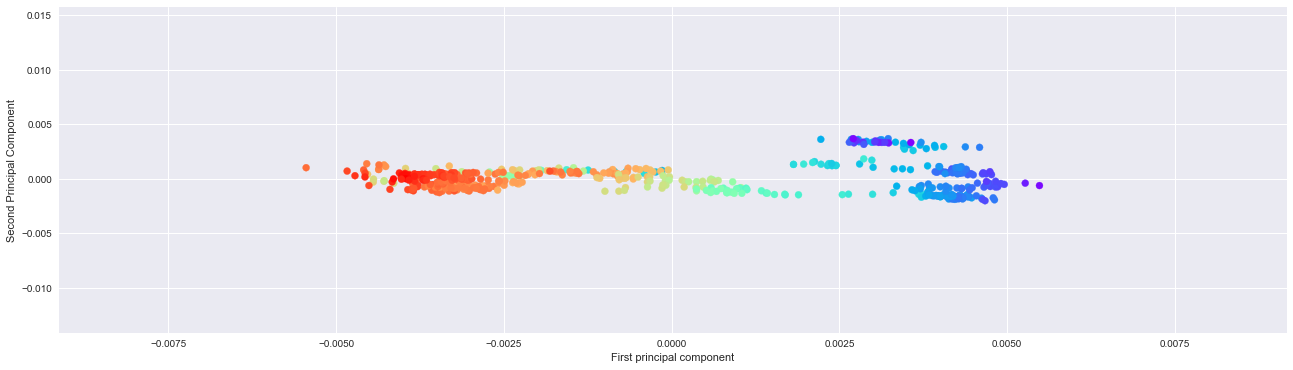

In [332]:
plt.figure(figsize=(22,6))
plt.scatter( x_pca[:,0],x_pca[:,1],c=df['EUR/USD'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [333]:
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print(name,' : ',pca.components_[0][loop],' - ',pca.components_[1][loop])
    

EUR/USD  :  -0.5194877420782187  -  -0.1157576240831548
AUD/USD  :  -0.2596454063146429  -  0.7105061722999932
CHF/USD  :  -0.3402341970806853  -  -0.6789381766914871
GBP/USD  :  -0.7395407702652785  -  0.14424849310913085
JPY/USD  :  -0.006073636676539286  -  -0.004059070930446812


In [334]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
jh_results = johasen(df,0,1)
print('\nTrace Statistisque \n',jh_results.lr1)                           # dim = (n,) Trace statistic
print('\n\nCritical Value \n',jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print('\n\nEigein Velue ec \n',jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]
print('\n\nProbabilité de Eigein \n',jh_results.eig)
if jh_results.eig[0] <= 0.05:
    print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
else:
    print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)


Trace Statistisque 
 [53.8064231  30.15134564 17.42142907  6.97447574  0.48620119]


Critical Value 
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


Eigein Velue ec 
 [[ 6.72774157e+02 -2.98370191e+02 -1.69630002e+03  4.70295867e+02
  -5.45725210e+01]
 [-1.33800984e+03  5.21444774e+02  4.31519601e+02 -6.25304584e+02
  -4.07227764e+02]
 [ 2.13241292e+02  8.06182758e+02  8.12063137e+02 -1.04448694e+03
   5.02864327e+02]
 [ 1.58376301e+03  2.01286810e+02  6.49716207e+02  1.67916444e+02
  -3.29853673e+02]
 [-1.93948251e+05 -8.86259793e+04 -4.09126298e+03 -1.15583419e+04
   9.94042682e+03]]


Probabilité de Eigein 
 [0.04114568 0.02235715 0.01838477 0.01145831 0.00086322]

Test de cointiégration de Johasen   VALIDE! 


In [335]:
from sklearn.linear_model import LinearRegression

X = df.iloc[:,1:]
y = df.iloc[:,0]
reg = LinearRegression().fit(X, y)
score = reg.score(X, y) *100
coef = reg.coef_
cste = reg.intercept_

if score > 70:
    print('Test ',Fore.GREEN,'VALIDE',Style.RESET_ALL,' avec un score de ',Fore.GREEN,round(score,2),Style.RESET_ALL,'%')
    print("Les poids respectifs sont de :")
    loop = -1
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

elif score > 50:
    print('Test ',Fore.YELLOW,'MITIGE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,round(score,2),Style.RESET_ALL,'%')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

else:
    print('Test ',Fore.RED,'NON VALIDE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,round(score,2),Style.RESET_ALL,'%')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)


Test   VALIDE   avec un score de   91.08  %
Les poids respectifs sont de :
AUD/USD  :  0.5648950706206508
CHF/USD  :  0.5540077943953825
GBP/USD  :  -0.008484054263953223
JPY/USD  :  29.125938880800902
Et la constante est :  -0.0938412641285995


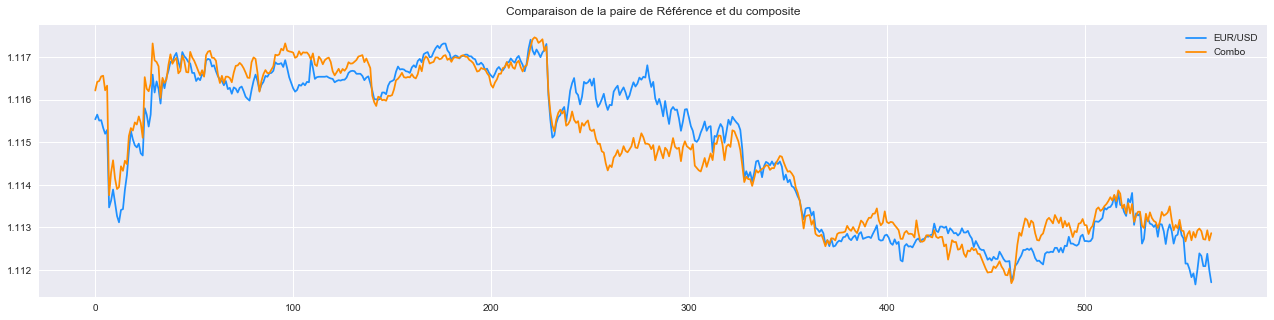

In [336]:
combo = cste + coef[0] * df['AUD/USD'] + coef[1] * df['CHF/USD'] + coef[2] * df['GBP/USD'] + coef[3] * df['JPY/USD']
plt.figure(figsize=(22,5))
plt.plot(df['EUR/USD'],label = 'EUR/USD',c='dodgerblue')
plt.plot(combo,label = 'Combo',c='darkorange')
plt.title('Comparaison de la paire de Référence et du composite')
plt.legend()

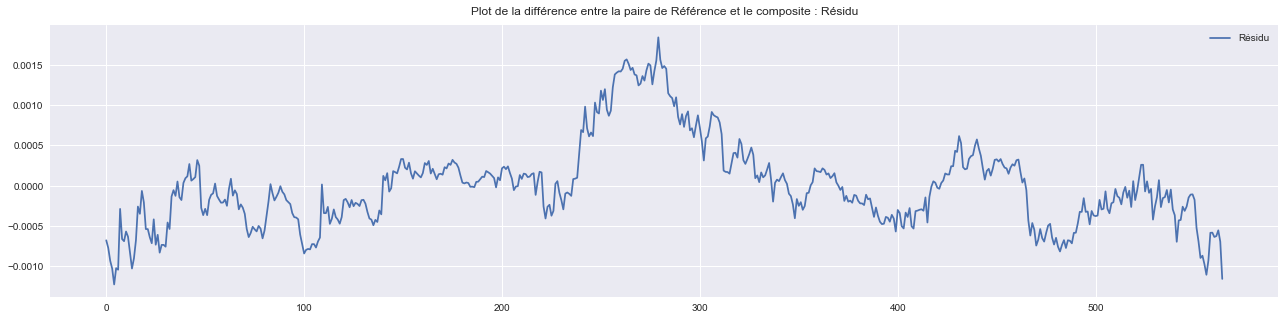

In [337]:
########
### RESIDUS
########
residu = df['EUR/USD']-combo
S = (residu - residu.mean())/residu.std()
plt.figure(figsize=(22,5))
plt.plot(residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA JPY/USD 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS JPY/USD 
 /!\ ATTENTION SUPISCION DE NORMALITE /!\ 
 TEST SKEWNESS ECHOUE 
 
TEST D'ASSYMETRIE: KURTOSIS JPY/USD 
Puisque le skewness ( -1.2821 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE JPY/USD 
JPY/USD :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000   522.301406  1.336111e-115
1  0.958924  0.960625  1012.810996  1.177298e-220
2  0.928458  0.116014  1473.405247   0.000000e+00
3  0.898901  0.013465  1908.792955   0.000000e+00
4  0.873180  0.039894  2319.706556   0.000000e+00
L'index de sortie de l'intervalle de confiance à 5% est de 4 . Il apparait donc clairement que la série n'es

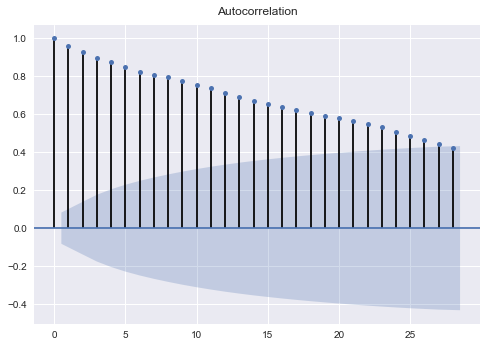

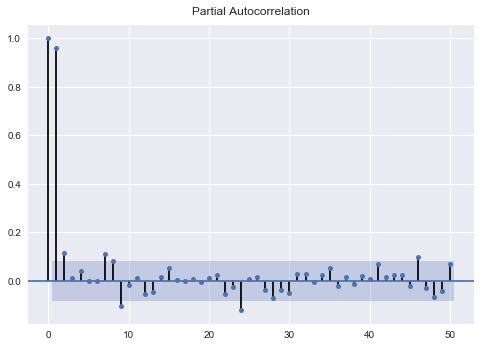

In [338]:
####
## ANALYSE DES RESIDUS
###

jarque_berra(residu)
skewness(residu)
kurtos(residu)
residu_autocor = pd.DataFrame()
residu_autocor['Close'] = residu.iloc[:]
autocor(residu_autocor)
print("La moyenne des résidus est de ",residu.mean(),", et leur ecart-type vaut ",residu.std())

In [339]:
model = sm.OLS(residu,residu.index)
results = model.fit()
residuals = results.resid
summary = results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.1099
Date:                Wed, 04 Mar 2020   Prob (F-statistic):                       0.740
Time:                        14:46:21   Log-Likelihood:                          3456.4
No. Observations:                 565   AIC:                                     -6911.
Df Residuals:                     564   BIC:                                     -6906.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000   522.301406  1.336111e-115
1  0.958924  0.960625  1012.810996  1.177298e-220
2  0.928458  0.116014  1473.405247   0.000000e+00
3  0.898901  0.013465  1908.792955   0.000000e+00
4  0.873180  0.039894  2319.706556   0.000000e+00
L'index de sortie de l'intervalle de confiance à 5% est de 4 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

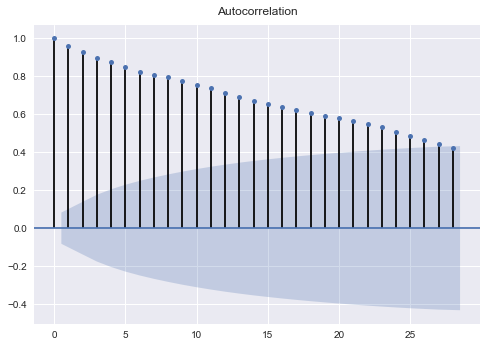

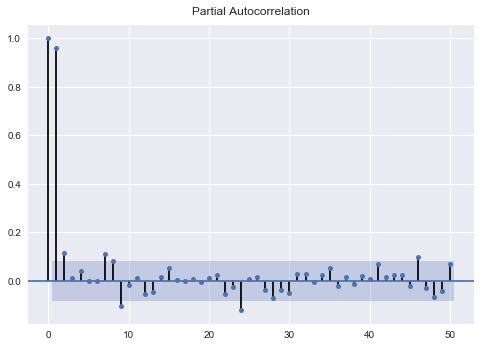

In [340]:
temp = pd.DataFrame()
temp['Close'] = residu.iloc[:]
autocor(temp)

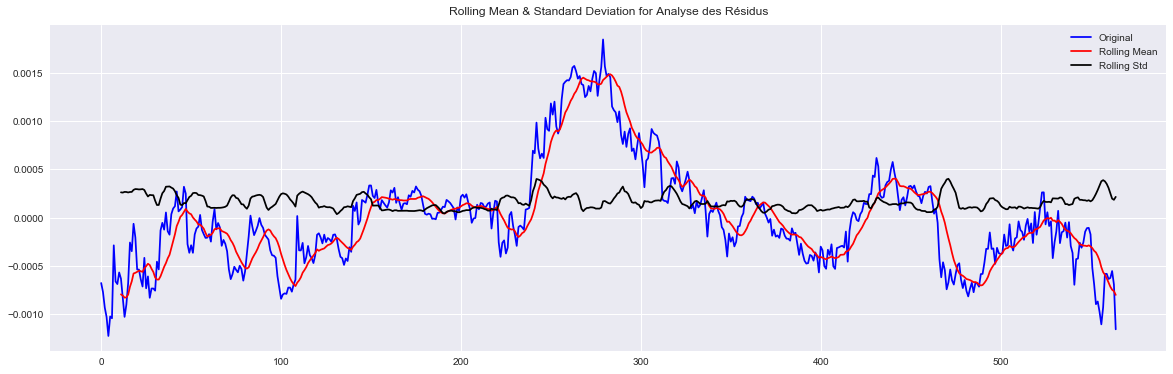

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -2.674971
p-value                          0.078470
#Lags Used                       1.000000
Number of Observations Used    563.000000
Critical Value (1%)             -3.442019
Critical Value (5%)             -2.866687
Critical Value (10%)            -2.569511
dtype: float64
Le test est   NON VALIDE  et le résidu  :   NON STATIONNAIRE 


In [341]:
dfoutput =  test_stationarity(residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)

   

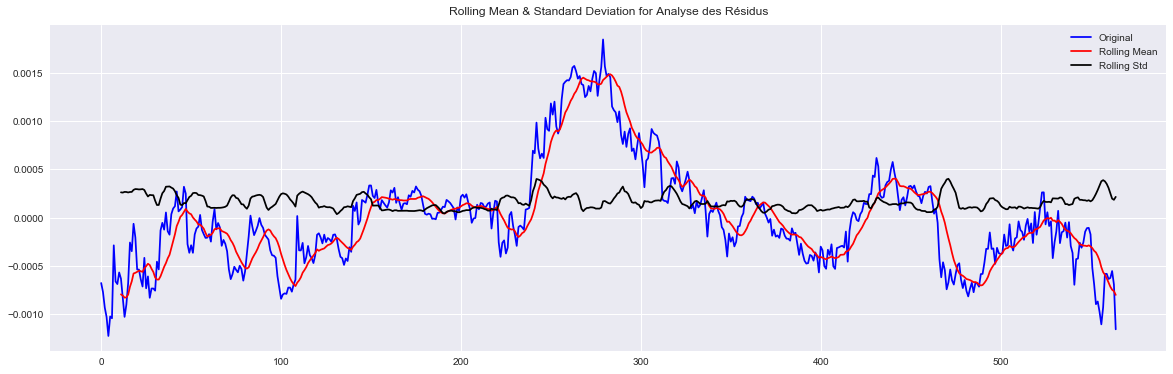

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -2.950050
p-value                          0.039830
#Lags Used                       0.000000
Number of Observations Used    564.000000
Critical Value (1%)             -3.441998
Critical Value (5%)             -2.866678
Critical Value (10%)            -2.569506
dtype: float64
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 


In [342]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)


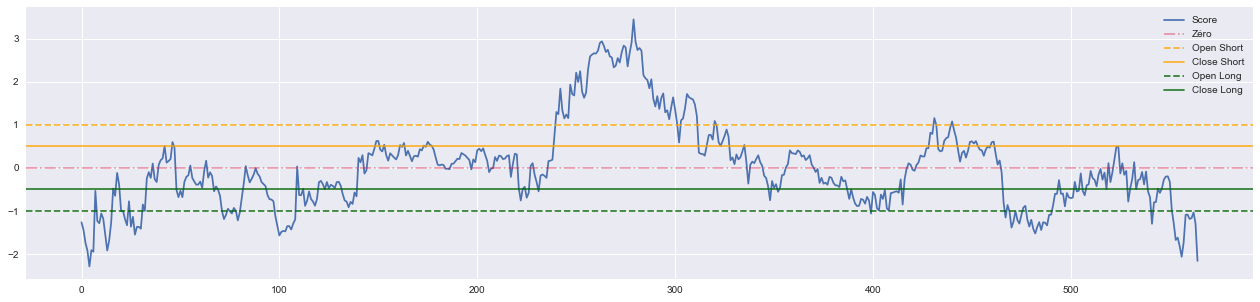

In [343]:
plt.figure(figsize=(22,5))
plt.plot(S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [344]:
########
### BT
#######



In [345]:
bt_df = pd.DataFrame()
for bt_pair in bt_PAIR:
    
    if bt_pair.equals(bt_eurusd):
        name = 'EUR/USD'
    elif bt_pair.equals(bt_audusd):
        name = 'AUD/USD'
    elif bt_pair.equals(bt_chfusd):
        name = 'CHF/USD'
    elif bt_pair.equals(bt_gbpusd):
        name = 'GBP/USD'
    elif bt_pair.equals(bt_jpyusd):
        name = 'JPY/USD'
    
    
    bt_df[name] = list(bt_pair['Close'])
bt_df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD
EUR/USD,1.000000,0.495633,0.826374,0.855076,0.581216
AUD/USD,0.495633,1.000000,0.076414,0.385890,-0.256608
CHF/USD,0.826374,0.076414,1.000000,0.744802,0.810275
GBP/USD,0.855076,0.385890,0.744802,1.000000,0.533913
JPY/USD,0.581216,-0.256608,0.810275,0.533913,1.000000


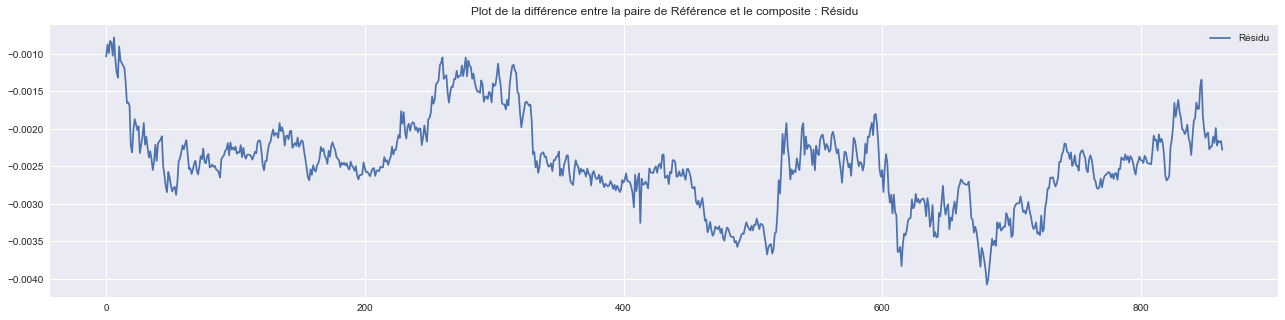

In [346]:
bt_combo = cste + coef[0] * bt_df['AUD/USD'] + coef[1] * bt_df['CHF/USD'] + coef[2] * bt_df['GBP/USD'] + coef[3] * bt_df['JPY/USD']
bt_residu = bt_df['EUR/USD']-bt_combo
bt_S = (bt_residu - bt_residu.rolling(window=400).mean())/bt_residu.rolling(window=400).mean()
plt.figure(figsize=(22,5))
plt.plot(bt_residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA JPY/USD 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS JPY/USD 
Puisque le skewness ( 0.8918 ) de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE
 TEST SKEWNESS VALIDE 
 
TEST D'ASSYMETRIE: KURTOSIS JPY/USD 
Puisque le skewness ( 1.0525 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE JPY/USD 
JPY/USD :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000   814.174304  4.470395e-179
1  0.969055  0.970178  1587.360673   0.000000e+00
2  0.943800  0.080761  2321.903927   0.000000e+00
3  0.919379  0.009805  3011.452554   0.000000e+00
4  0.890258 -0.090672  3664.569822   0.000000e+00
L'index de sortie de l'intervall

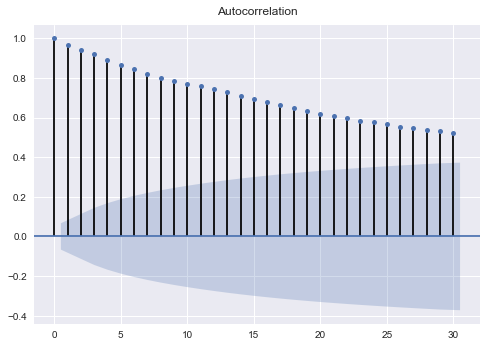

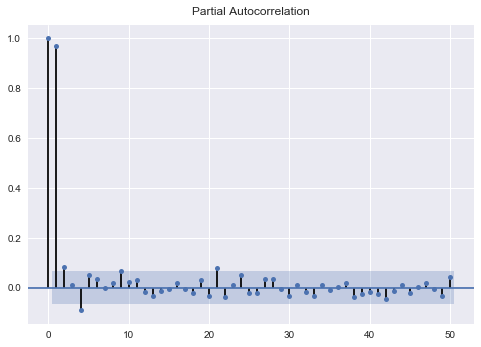

In [347]:
jarque_berra(bt_residu)
skewness(bt_residu)
kurtos(bt_residu)
bt_residu_autocor = pd.DataFrame()
bt_residu_autocor['Close'] = bt_residu.iloc[:]
autocor(bt_residu_autocor)
print("La moyenne des résidus est de ",bt_residu.mean(),", et leur ecart-type vaut ",bt_residu.std())

In [348]:
bt_model = sm.OLS(bt_residu,bt_residu.index)
bt_results = bt_model.fit()
bt_residuals = bt_results.resid
bt_summary = bt_results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(bt_model,bt_results, bt_residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              3112.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):                   1.74e-288
Time:                        14:46:29   Log-Likelihood:                          4600.7
No. Observations:                 864   AIC:                                     -9199.
Df Residuals:                     863   BIC:                                     -9195.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000   814.174304  4.470395e-179
1  0.969055  0.970178  1587.360673   0.000000e+00
2  0.943800  0.080761  2321.903927   0.000000e+00
3  0.919379  0.009805  3011.452554   0.000000e+00
4  0.890258 -0.090672  3664.569822   0.000000e+00
L'index de sortie de l'intervalle de confiance à 5% est de 2 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

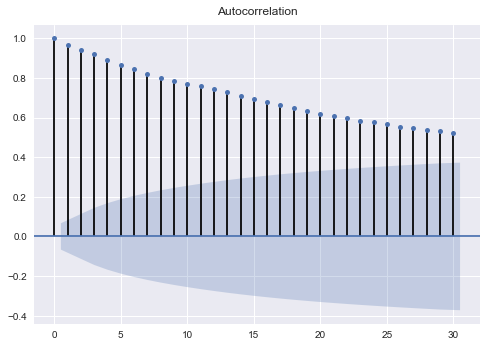

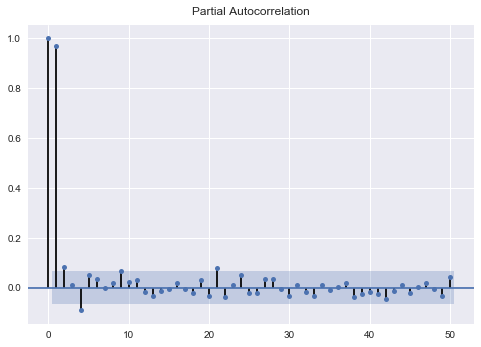

In [349]:
temp = pd.DataFrame()
temp['Close'] = bt_residu.iloc[:]
autocor(temp)

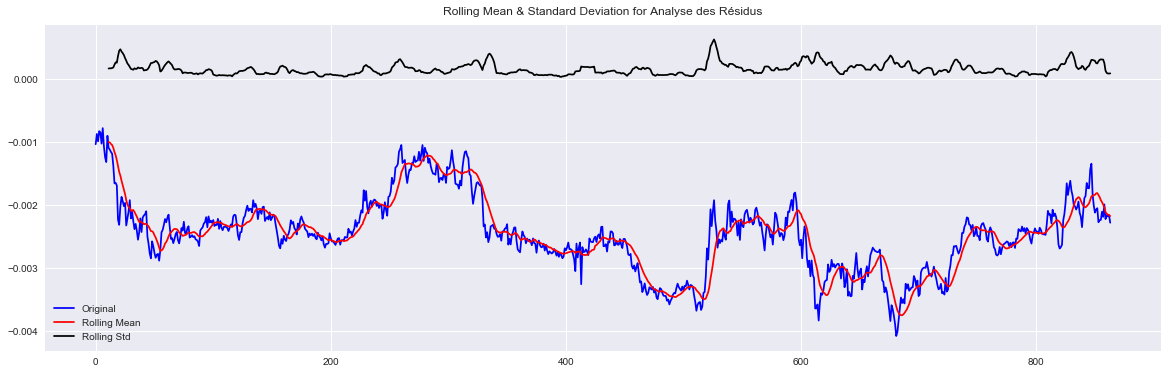

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -3.692133
p-value                          0.004225
#Lags Used                       1.000000
Number of Observations Used    862.000000
Critical Value (1%)             -3.437959
Critical Value (5%)             -2.864899
Critical Value (10%)            -2.568558
dtype: float64
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 


In [350]:
dfoutput =  test_stationarity(bt_residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)


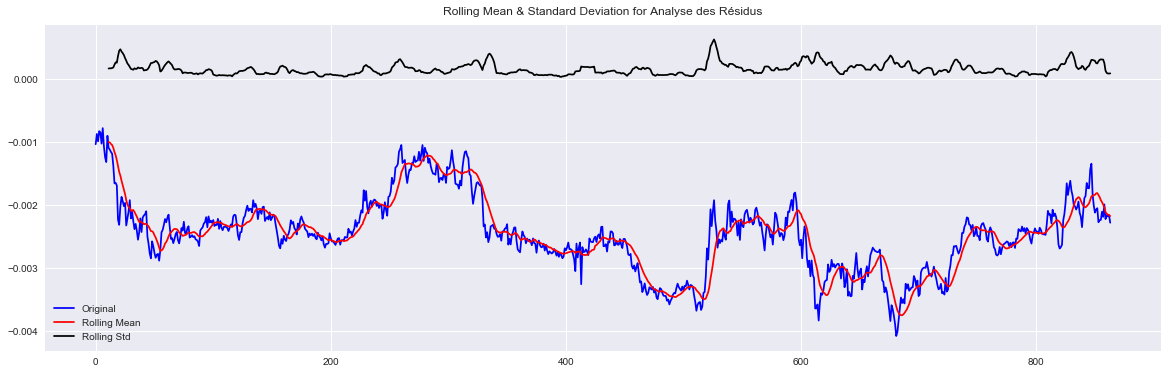

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -3.899983
p-value                          0.002035
#Lags Used                       0.000000
Number of Observations Used    863.000000
Critical Value (1%)             -3.437950
Critical Value (5%)             -2.864895
Critical Value (10%)            -2.568556
dtype: float64
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 


In [351]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(bt_residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)

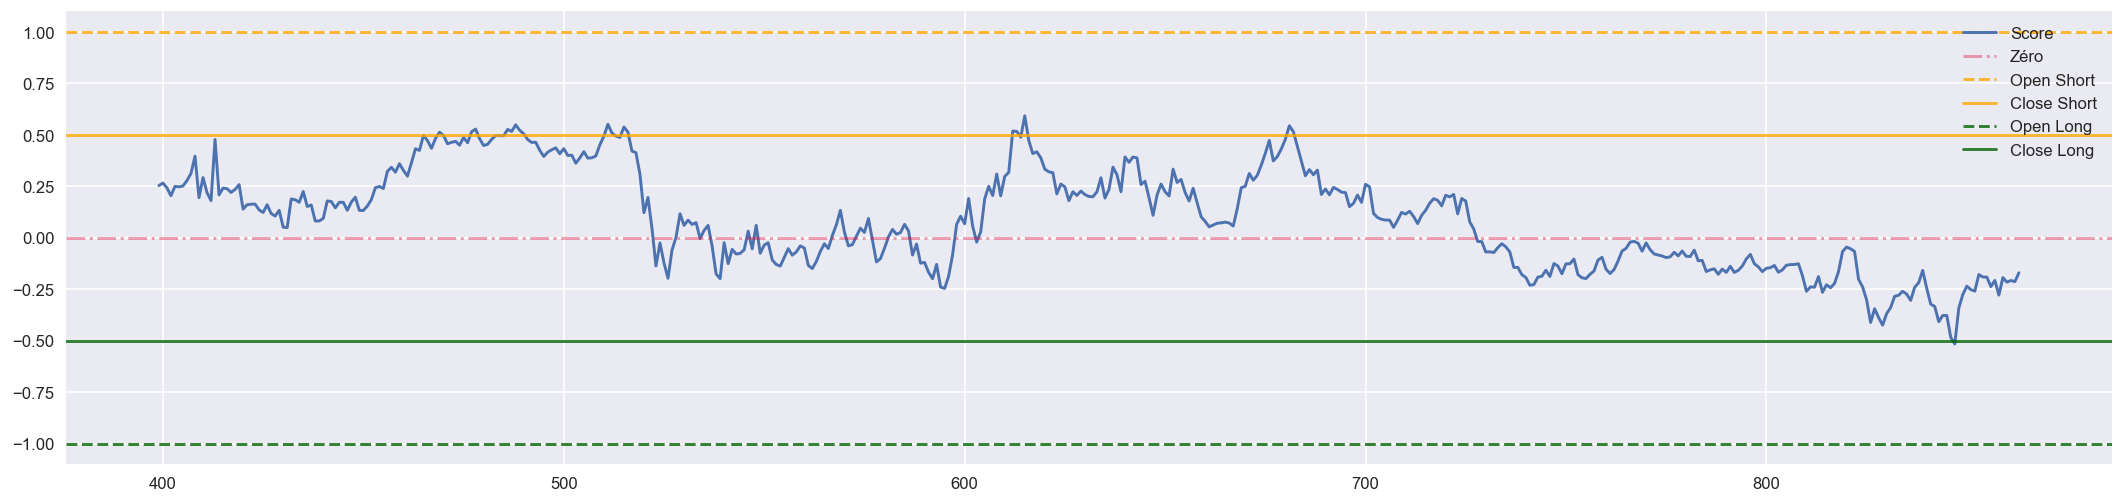

In [352]:
plt.figure(figsize=(22,5),dpi=120)
plt.plot(bt_S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [353]:
backtest_df = pd.DataFrame()
backtest_df = bt_df
backtest_df.index = bt_pair['Local time']
backtest_df['Spread'] = bt_residu.to_list()
backtest_df['Signals'] = bt_S.to_list()
backtest_df.tail()

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD,Spread,Signals
Local time,,,,,,,
2019-11-08 12:35:00,1.10285,0.68648,1.003039,1.27974,0.009143,-0.002221,-0.193162
2019-11-08 12:40:00,1.10298,0.68662,1.003110,1.27963,0.009141,-0.002159,-0.215123
2019-11-08 12:45:00,1.10284,0.68646,1.003039,1.27964,0.009141,-0.002180,-0.207230
2019-11-08 12:50:00,1.10297,0.68652,1.003200,1.27996,0.009141,-0.002163,-0.212737
2019-11-08 12:55:00,1.10289,0.68655,1.003230,1.28022,0.009141,-0.002279,-0.169674




TAILLES DES POSITIONS :
EUR/USD :  100000
AUDUSD :  56489.50706206508
CHF/USD :  55400.77943953825
GBP/USD :  -848.4054263953224
JPY/USD :  2912593.8880800903


 ------------------------------------------------------------------------
 --------------------------------RESULTATS-------------------------------
 ------------------------------------------------------------------------ 
Nombre de trades long :  0
Nombre de trades short :  0


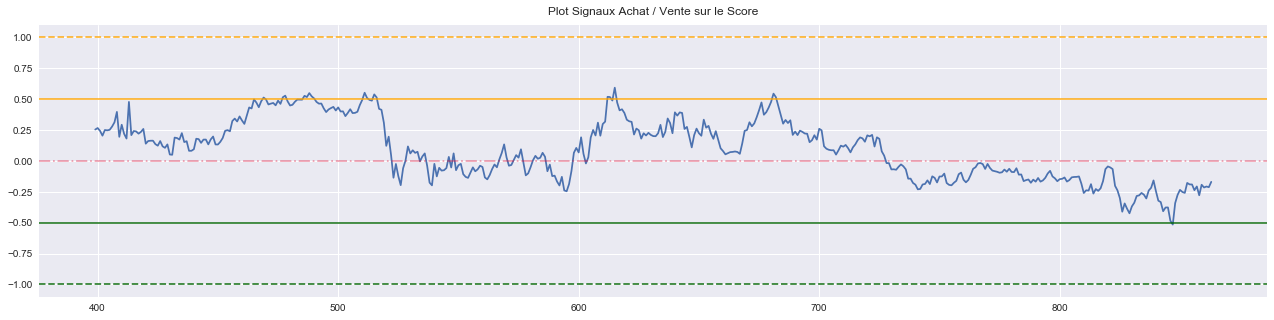

In [354]:
plt.figure(figsize=(22,5))
_plot = plt.plot(bt_S,label = 'Score')
os,cs,ol,cl = 0,0,0,0

mise = 100000
profit_long = 0
profit_short = 0
profit = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnls = 0
pnll = 0

buy1 = 0
buy2 = 0
buy3 = 0
sell1 = 0
sell2 = 0
sell3 = 0
nbposl= 0
nbposs = 0
print('\n\nTAILLES DES POSITIONS :')
print('EUR/USD : ', mise)
print('AUDUSD : ',coef[0] * mise)
print('CHF/USD : ',coef[1] * mise)
print('GBP/USD : ',coef[2] * mise)
print('JPY/USD : ',coef[3] * mise)
print('\n')

for mark in range(0,len(backtest_df)):
    if backtest_df.iloc[mark]['Signals'] > 1 and backtest_df.iloc[mark]['Signals'] < 2 and os == 0 and sell1 == 0:
        _os = scatter =  plt.scatter(x=mark,y=bt_S[mark],c='r',marker='o',label='Open Short')
        os = 1
        cs = 0
        sell1 = 1
        nbposs = 1
        eos = mise * backtest_df.iloc[mark]['EUR/USD']
        auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])  
    
    if backtest_df.iloc[mark]['Signals'] > 2 and backtest_df.iloc[mark]['Signals'] < 3 and sell2 == 0:
        _os = scatter =  plt.scatter(x=mark,y=bt_S[mark],c='r',marker='o',label='Open Short')
        os = 1
        cs = 0
        sell2 = 1
        nbposs = 1
        eos = mise * backtest_df.iloc[mark]['EUR/USD']
        auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 
        
    if backtest_df.iloc[mark]['Signals'] > 3 and backtest_df.iloc[mark]['Signals'] < 4 and sell3 == 0:
        _os = scatter =  plt.scatter(x=mark,y=bt_S[mark],c='r',marker='o',label='Open Short')
        os = 1
        cs = 0
        sell3 = 1
        nbposs = 1
        eos = mise * backtest_df.iloc[mark]['EUR/USD']
        auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])  
    
    if backtest_df.iloc[mark]['Signals'] < 0.5 and os >= 1 :
        _cs = scatter = plt.scatter(x=mark,y=bt_S[mark],c='r',marker='x',label='Close Short : ')
        os = 0
        cs = 1
        sell1 = 0
        sell2 = 0
        sell3 = 0
      
      
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 
        
        
        ecs = - mise*nbposs * backtest_df.iloc[mark]['EUR/USD']
        aucs = mise*nbposs * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcs = mise*nbposs * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcs = mise*nbposs * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcs = mise *nbposs* coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) 
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) 
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos
        
        nbre_trade += 1
        nbre_trade_short +=1
        
        profit = profit + pnls
        nbposs = 0
        
        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
              '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)
        
    if backtest_df.iloc[mark]['Signals'] > 4 and os == 1:
        _cs = scatter = plt.scatter(x=mark,y=bt_S[mark],c='r',marker='x',label='Close Short : ')
        os = 0
        cs = 1
        sell1 = 0
        sell2 = 0
        sell3 = 0
        
      
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 
        
        
        ecs = - mise *nbposs* backtest_df.iloc[mark]['EUR/USD']
        aucs = mise *nbposs* coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcs = mise *nbposs* coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcs = mise *nbposs* coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcs = mise *nbposs* coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) 
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) 
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos
        
        nbre_trade += 1
        nbre_trade_short +=1
        
        profit = profit + pnls
        nbposs = 0
        
        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
              '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)
        
    if backtest_df.iloc[mark]['Signals'] < -1 and backtest_df.iloc[mark]['Signals'] > -2 and ol == 0 and buy1 == 0:
        _ol = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='o',label='Open Long')
        ol = 1
        os = 0
        buy1 = 1
        nbposl = 1
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        eol = - mise * backtest_df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
    if backtest_df.iloc[mark]['Signals'] < -2 and backtest_df.iloc[mark]['Signals'] > -3 and buy2 == 0:
        _ol = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='o',label='Open Long')
        ol = 1
        os = 0
        buy2 = 1
        nbposl = 1
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        eol = - mise * backtest_df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
    if backtest_df.iloc[mark]['Signals'] < -3 and backtest_df.iloc[mark]['Signals'] > -4 and buy3 == 0:
        _ol = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='o',label='Open Long')
        ol = 1
        os = 0
        buy3 = 1
        nbposl = 1
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        eol = - mise * backtest_df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
    if backtest_df.iloc[mark]['Signals'] > -0.5 and ol == 1 :
        _cl = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='x',label='Close Long')
        ol = 0
        cl = 1
        buy1 = 0
        buy2 = 0
        buy3 = 0
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        ecl = mise *nbposl* backtest_df.iloc[mark]['EUR/USD']
        aucl = -  mise*nbposl * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcl = - mise*nbposl * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcl = - mise *nbposl* coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcl = - mise *nbposl* coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) 
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) 
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol
        
        nbre_trade += 1
        nbre_trade_long +=1
        
        profit = profit + pnll
        nbposl = 0
        
        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
              '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)
        
        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)

    
    if backtest_df.iloc[mark]['Signals'] < -4 and ol == 1:
        _cl = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='x',label='Close Long')
        ol = 0
        cl = 1
        buy1 = 0
        buy2 = 0
        buy3 = 0
       
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Stop Loss',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        ecl = mise*nbposl * backtest_df.iloc[mark]['EUR/USD']
        aucl = -  mise *nbposl* coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcl = - mise *nbposl* coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcl = - mise *nbposl* coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcl = - mise *nbposl* coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) 
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) 
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol
        
        nbre_trade += 1
        nbre_trade_long +=1
        
        profit = profit + pnll
        nbposl = 0
        
        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
              '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)
        
        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)
    
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.title('Plot Signaux Achat / Vente sur le Score')
try:
    plt.legend((_os,_cs,_ol,_cl),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )
except:
    pass

    
print(Fore.YELLOW,'------------------------------------------------------------------------')
print(' --------------------------------RESULTATS-------------------------------')
print(' ------------------------------------------------------------------------',Style.RESET_ALL)
if profit < 0:
    print('Le profit généré en $',Fore.RED,round(profit,2),Style.RESET_ALL)
    

if profit > 0:
    print('Le profit généré en $',Fore.GREEN,round(profit,2),Style.RESET_ALL)

print('Nombre de trades long : ',nbre_trade_long)
print('Nombre de trades short : ',nbre_trade_short)
    

In [355]:
residu.mean(),bt_residu.mean(),residu.std(),bt_residu.std()

(1.5248372869187992e-16,
 -0.002461096635380541,
 0.0005337895635376655,
 0.0005803074531739662)

In [356]:
bt_residu.mean(),bt_residu.std()

(-0.002461096635380541, 0.0005803074531739662)

In [357]:
bt_residu.rolling(window=12).std()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
859    0.000131
860    0.000095
861    0.000086
862    0.000086
863    0.000088
Length: 864, dtype: float64